In [1]:
import sys

MODULE_FULL_PATH = 'D:/python_modules'

sys.path.insert(1, MODULE_FULL_PATH)

In [2]:
import ee
import geemap
import pandas as pd
import numpy as np
from tqdm import tqdm

In [3]:
ee.Initialize()

In [4]:
import wrapper as wp #https://github.com/adugnag/gee_s1_ard

In [5]:
import uuid
from IPython.core.display import display, HTML

import json
import yaml

def eeprint(obj):
    id = str(uuid.uuid4())
    if isinstance(obj, ee.computedobject.ComputedObject):
        obj = obj.getInfo()
    try:
        obj = yaml.load(str(obj), Loader=yaml.SafeLoader)
    except:
        pass
    if isinstance(obj, dict):
        json_str = json.dumps(obj)   
    elif isinstance(obj, str):
        return display(HTML('<div id="{}" style="height: auto; width:100%;">{}</div>'.format(id, obj)))
    else:
        json_str = str(obj)
    display(HTML('<div id="{}" style="height: auto; width:100%;"></div>'.format(id)))
    display(HTML("""
        <script src="/static/components/requirejs/require.js"></script> <!-- Needed in Colab -->
        <script>
            require(["https://rawgit.com/caldwell/renderjson/master/renderjson.js"], function() {
              renderjson.set_show_to_level(1)
              document.getElementById('%s').appendChild(renderjson(%s))
            });
        </script>
    """ % (id, json_str)))

### Draw a AOI

In [6]:
Map = geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [7]:
aoi = Map.draw_last_feature
aoi = aoi.geometry()

In [8]:
# Function to filter out images which do not fully cover the study area
def getCover(image, aoi=aoi, scale=30):

    # calculate the number of inputs
    totPixels = ee.Number(image.unmask(1).reduceRegion(**{
      'reducer': ee.Reducer.count(),
      'scale': scale,
      'geometry': aoi,
    }).values().get(0))

    # Calculate the actual amount of pixels inside the aoi
    actPixels = ee.Number(image.reduceRegion(**{
      'reducer': ee.Reducer.count(),
      'scale': scale,
      'geometry': aoi,
    }).values().get(0))

    # calculate the perc of cover
    percCover = actPixels.divide(totPixels).multiply(100).round()

    # number as output
    return image.set('percCover', percCover)

In [9]:
L81C = ee.ImageCollection("LANDSAT/LC08/C01/T1_TOA")

In [10]:
S1grd = ee.ImageCollection('COPERNICUS/S1_GRD')

In [11]:
S21C = ee.ImageCollection('COPERNICUS/S2')

In [12]:
GSW = ee.ImageCollection("JRC/GSW1_3/MonthlyHistory")

In [13]:
def filter_data(aoi, 
                endDate,
                startDate = '2022-01-01',
                cloud_cover_threshold = 5,
                water_data = 'GSW'):
    """
    Filters and adds required bands for water extent and aquatic vegetation detection.
    
    Args:
        aoi(geometry): the waterbody to extract data for
        endDate(str): date of the format 'YYYY-MM-DD'
        startDate(str): date of the format 'YYYY-MM-DD'
        cloud_cover_threshold (int): percentage cloud cover allowed for sentinel-2 and
            Landsat-8 data. Default: 5% cloud cover allowed.
        water_data (str): imagecollection containing surface water extent data. Default:
            the Global Surface Water ('GSW') data (Pekel et al., 2016)
        radar_band(str): S1 radar band used to detect aquatic vegetation. 'VV' or 'VH'.
            Default: 'VV'.
        
    Returns: An ImageCollection with Landsat-8, Sentinel-2 and Sentinel-1 data that meets
        filter criteria, bands to detect aquatic vegetation and total water extent area (squared metres)
        
    """
    # filter data
    #Landsat-8
    L8 = L81C.filterBounds(aoi).filterDate(startDate,endDate)\
        .filter(ee.Filter.lte('CLOUD_COVER', cloud_cover_threshold))\
        .select(['B5','B4']).map(lambda x: x.clip(aoi).rename(['NIR','Red'])\
        .copyProperties(x, ['sytem:time_start']).set('sensor', 'L8'))\
        .map(getCover).filter(ee.Filter.eq('percCover', 100))
    #Sentinel-2
    S2 = S21C.filterBounds(aoi).filterDate(startDate,endDate)\
        .filter(ee.Filter.lte('CLOUD_COVERAGE_ASSESSMENT', cloud_cover_threshold))\
        .select(['B8','B4']).map(lambda x: x.clip(aoi).rename(['NIR','Red'])\
        .copyProperties(x, ['sytem:time_start']).set('sensor', 'S2'))\
        .map(getCover).filter(ee.Filter.eq('percCover', 100))
    #Sentinel-1
    parameters.update({'STOP_DATE': endDate, 'START_DATE': startDate})
    S1 = wp.s1_preproc(parameters).map(getCover).filter(ee.Filter.eq('percCover', 100))#.filter(ee.Filter.contains('.geo', aoi))
    S1 = S1.select('VV').map(lambda x: x.set('sensor', ee.String('S1').cat(x.get("platform_number"))))
    water = GSW#.filterBounds(aoi).filterDate(startDate,endDate)
    
    #Calculate required bands for the most recent water extent and copy sensor, date and water area properties
    def ndvi(img):
        recent_water = water.filterDate('2013-01-01',img.date()).map(lambda i: i.clip(aoi).gte(2).selfMask()\
                                        .addBands(ee.Image.constant(ee.Number.parse(i.date().format("YYYYMMdd"))))\
                                        .rename(['water','date']).float()).qualityMosaic('date').select('water')
        ndvi = img.clip(aoi).updateMask(recent_water).normalizedDifference(['NIR','Red']).rename('pre_veg')\
        .set('date', ee.Number.parse(img.date().format("YYYYMMdd")))\
        .copyProperties(img,['sensor'])\
        .set('water_area', ee.Number(recent_water.multiply(ee.Image.pixelArea()).reduceRegion(**{\
            'reducer':ee.Reducer.sum(), 'geometry':aoi, 'scale': 30, 'maxPixels': 1e13}).get('water')).divide(1e6))
        return ndvi
    
    def vv(img):
        recent_water = water.filterDate('2013-01-01',img.date()).map(lambda i: i.clip(aoi).gte(2).selfMask()\
                                        .addBands(ee.Image.constant(ee.Number.parse(i.date().format("YYYYMMdd"))))\
                                        .rename(['water','date']).float()).qualityMosaic('date').select('water')
        vv = img.updateMask(recent_water).rename('pre_veg')\
        .set('date', ee.Number.parse(img.date().format("YYYYMMdd")))\
        .copyProperties(img,['sensor'])\
        .set('water_area', ee.Number(recent_water.multiply(ee.Image.pixelArea()).reduceRegion(**{\
            'reducer':ee.Reducer.sum(), 'geometry':aoi, 'scale': 30, 'maxPixels': 1e13}).get('water')).divide(1e6))
        return vv
                    
    #Merge collections
    print(f"Number of Landsat-8 images: {L8.size().getInfo()}")
    print(f"Number of Sentinel-2 images: {S2.size().getInfo()}")
    print(f"Number of Sentinel-1 images: {S1.size().getInfo()}")
    coll = L8.map(ndvi).merge(S2.map(ndvi)).merge(S1.map(vv))
    return coll

# S1 Pre-processing 

### Citation
Mullissa, A.; Vollrath, A.; Odongo-Braun, C.; Slagter, B.; Balling, J.; Gou, Y.; Gorelick, N.; Reiche, J. Sentinel-1 SAR Backscatter Analysis Ready Data Preparation in Google Earth Engine. Remote Sens. 2021, 13, 1954. https://doi.org/10.3390/rs13101954

In [14]:
parameters = {#1. Data Selection
              'START_DATE': "2020-01-01",
              'STOP_DATE': "2020-03-31",
              'POLARIZATION':'VV',
              'PLATFORM_NUMBER': ['A','B'],
              'ORBIT' : 'BOTH',
              'ORBIT_NUM': None,
              'ROI': aoi, 
              #2. Additional Border noise correction
              'APPLY_BORDER_NOISE_CORRECTION': True,
              #3.Speckle filter
              'APPLY_SPECKLE_FILTERING': True,
              'SPECKLE_FILTER_FRAMEWORK': 'MONO',
              'SPECKLE_FILTER': 'REFINED LEE',
              'SPECKLE_FILTER_KERNEL_SIZE': 15,
              'SPECKLE_FILTER_NR_OF_IMAGES': 10,
              #4. Radiometric terrain normalization
              'APPLY_TERRAIN_FLATTENING': True,
              'DEM': ee.Image("NASA/NASADEM_HGT/001"),
              'TERRAIN_FLATTENING_MODEL': 'VOLUME',
              'TERRAIN_FLATTENING_ADDITIONAL_LAYOVER_SHADOW_BUFFER': 0,
              #5. Output
              'FORMAT' : 'DB',
              'CLIP_TO_ROI': True,
              'SAVE_ASSET': False,
              'ASSET_ID':None}

# Option 2: Unsupervised k means(detect veg)

In [15]:
def detect_veg(image, minClusters=2, maxClusters=2):
    scale = image.projection().nominalScale()
    
    # Make the training dataset.
    training = image.sample(**{
      'region': image.geometry(),
      'scale': scale,
      'numPixels': 5000,
      'seed':0
    })

    # Instantiate the clusterer and train it.
    clusterer = ee.Clusterer.wekaKMeans(maxClusters).train(training)

    # Cluster the input using the trained clusterer.
    clusterimg = image.cluster(clusterer)
    
    # Recluster the training data and compute the mdiean for each cluster.
    clusters = training.cluster(clusterer, "cluster")
    groups = clusters.reduceColumns(ee.Reducer.median().group(0), ["cluster", "pre_veg"])

    # Extract the cluster IDs and the medians.
    groups = ee.List(groups.get("groups"))

    ids = groups.map(lambda d: ee.Dictionary(d).get('group'))

    medians = groups.map(lambda d: ee.Dictionary(d).get('median'))

    # Sort the IDs using the medians as keys.
    sorted = ee.Array(ids).sort(medians).toList()

    #Select remaining (veg) clusters
    veg = clusterimg.eq(ee.Number(sorted.get(0)))
    return ee.ImageCollection(veg.copyProperties(image, ['date', 'sensor', 'water_area', 'veg_area']))

# Extract water and veg data

In [16]:
def extract_batch_export(imagecollection,  step_size = 1):
    """
    function to extract area of water and detected aquatic vegetation into a pandas dataframe.
    
    Args:
        imagecollection (ee.ImageCollection): earth engine image collection with L8/S2/S1 images
        step_size (int): The number of elements to process at once. Must be less than equal to 5000
    
    Returns: 
        A pandas dataframe with four columns (date (YYYYMMDD), sensor, aquatic vegetation area, water area)
    
    """
    imagecollection = ee.ImageCollection(imagecollection)
    isize = imagecollection.size().getInfo()
    ilist = imagecollection.toList(isize)
    data = list()
    
    for i in tqdm(range(0,isize,step_size)):
        img = ee.Image(ee.ImageCollection.fromImages((ilist.slice(i,i+step_size))).first())
        task_no = str(int(round(i/step_size+1)))
        #print('Executing task '+ task_no)
        tsk_name = 'task' + task_no
        veg = detect_veg(img)
        vegarea = ee.Number((ee.Image(veg).multiply(ee.Image.pixelArea().divide(1e6))).rename('open_water_area').reduceRegion\
                    (**{'reducer':ee.Reducer.sum(),'scale': 30, 'maxPixels':1e13, 'geometry':aoi}));
        date =  ee.Dictionary(['date', veg.get('date')])
        sensor = ee.Dictionary(['sensor', veg.get('sensor')])
        waterarea = ee.Dictionary(['water_area', veg.get('water_area')])
        merge = date.combine(sensor).combine(vegarea).combine(waterarea)
        data.append(merge.getInfo())
    df = pd.DataFrame(data)
    return df

In [38]:
images = filter_data(aoi, startDate= '2018-10-05', endDate= '2020-07-10',  cloud_cover_threshold= 5)

Number of images in collection:  100
Additional border noise correction is completed
Mono-temporal speckle filtering is completed
Radiometric terrain normalization is completed
Number of Landsat-8 images: 49
Number of Sentinel-2 images: 142
Number of Sentinel-1 images: 100


# Sanity check (start)

In [22]:
i= images#.filterDate('2020-01-14','2022-02-14')
eeprint(i.size())

In [23]:
veg = ee.ImageCollection(i).map(detect_veg).first()
eeprint(veg)

In [24]:
Map.addLayer(i.first(), {'min':-20, 'max': -3})
Map.addLayer(veg)

# Sanity check (end)

In [40]:
df = extract_batch_export(images)

100%|██████████████████████████████████████████████████████████████████████████████| 291/291 [2:12:21<00:00, 27.29s/it]


In [41]:
df

,date,sensor,veg_area,water_area
0,20181010,L8,12.944147,18.610431
1,20181026,L8,13.385213,18.610431
2,20181111,L8,14.149761,18.611239
3,20181213,L8,15.446583,18.611239
4,20190319,L8,13.954393,18.616889
...,...,...,...,...
286,20200504,S1B,16.106450,18.682271
287,20200516,S1B,15.906532,18.682271
288,20200528,S1B,10.531979,18.682271
289,20200621,S1B,15.798465,18.682271


In [90]:
# df = pd.read_csv(r"D:\phd\Chapter_3\Data\rdk1819cover.csv")

In [42]:
df.sensor.value_counts()

S2     142
S1A     53
L8      49
S1B     47
Name: sensor, dtype: int64

In [51]:
df['percent_cover'] = df.open_water_area/df.water_area

In [53]:
import dateutil.parser as parser
datep = []
for date in df['date']:
    d = parser.parse(str(date))
    datep.append(d)
df['date'] = datep

df.head()

,date,sensor,veg_area,water_area,percent_cover
0,2018-10-10,L8,12.944147,18.610431,0.695532
1,2018-10-26,L8,13.385213,18.610431,0.719232
2,2018-11-11,L8,14.149761,18.611239,0.760280
3,2018-12-13,L8,15.446583,18.611239,0.829960
4,2019-03-19,L8,13.954393,18.616889,0.749556


In [54]:
df['date'] =pd.to_datetime(df.date)
df.sort_values(by = 'date')

,date,sensor,veg_area,water_area,percent_cover
244,2018-10-06,S1B,10.788633,18.610431,0.579709
49,2018-10-07,S2,13.068487,18.610431,0.702213
50,2018-10-09,S2,13.974425,18.610431,0.750892
0,2018-10-10,L8,12.944147,18.610431,0.695532
191,2018-10-16,S1A,10.231240,18.610431,0.549758
...,...,...,...,...,...
189,2020-06-30,S2,17.586595,18.682271,0.941352
243,2020-07-01,S1A,15.668784,18.682271,0.838698
48,2020-07-02,L8,17.281024,18.682271,0.924996
290,2020-07-03,S1B,13.502052,18.682271,0.722720


In [46]:
subopt = df[(df.sensor=='L8') | (df.sensor=='S2') ]
subrad = df[(df.sensor=='S1A') | (df.sensor=='S1B') ]

# Radar time series

D:\ProgramData\envs\main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


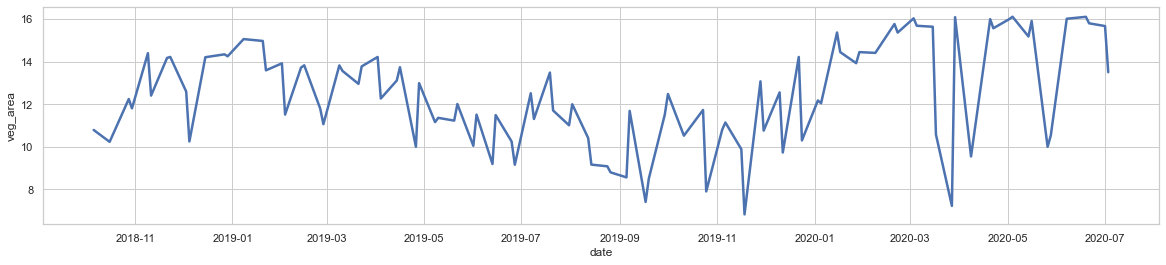

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

plt.figure(figsize=(20,4))

fig = sns.lineplot(subrad.date, subrad.veg_area, palette="tab10", linewidth=2.5, data=subrad)

# Optical time series

D:\ProgramData\envs\main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


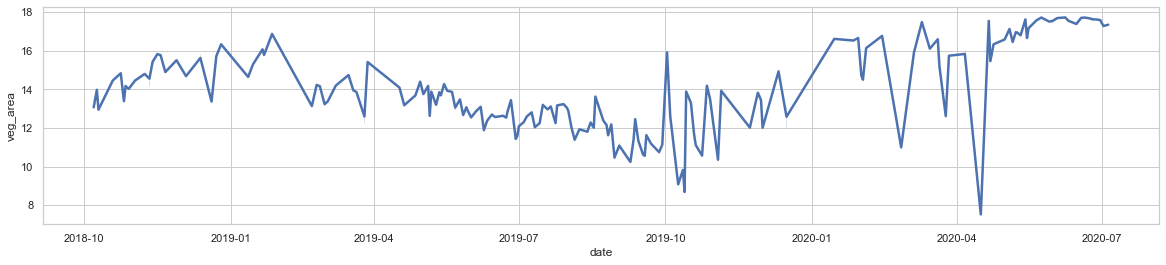

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

plt.figure(figsize=(20,4))

fig = sns.lineplot(subopt.date, subopt.veg_area, palette="tab10", linewidth=2.5, data=subopt)

# Combined time series

D:\ProgramData\envs\main\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


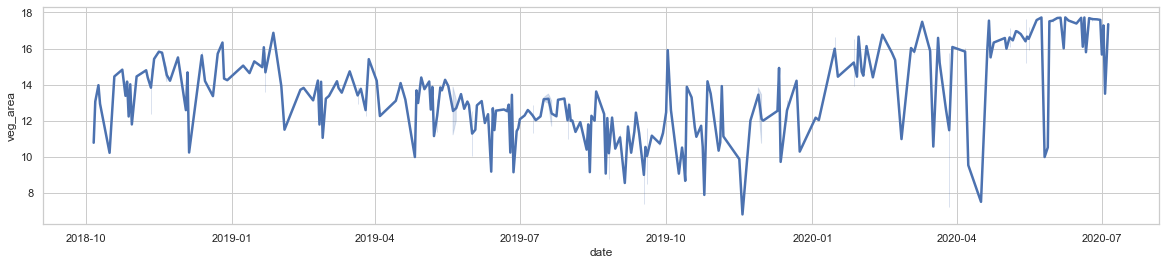

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

plt.figure(figsize=(20,4))

fig = sns.lineplot(df.date, df.veg_area, palette="tab10", linewidth=2.5, data=subrad)

In [50]:
df.to_csv(r"D:\phd\Chapter_3\Data\hpdcover.csv")

# Extract covariates (wind, temp, precipitation)

In [57]:
## Calculate wind speed
def wind_speed (image):
    speed = image.expression(
     'spd = sqrt(u**2 + v**2)', {
       "u": image.select('u_component_of_wind_10m'),\
        'v': image.select('v_component_of_wind_10m')
      }).rename('wind_speed')
    return speed.set('system:time_start', image.get('system:time_start'));

## Calculate wind direction
def wind_direction (image):
    dir = image.expression(
     'dir = mod(180 + (180/3.14) * atan2(v,u),360)', {
       "u": image.select('u_component_of_wind_10m'),\
        'v': image.select('v_component_of_wind_10m')
      }).rename('winddir')
    return dir.set('system:time_start', image.get('system:time_start'));

In [58]:
# Define a function to transfer feature properties to a dictionary.
def fc_to_dict(fc):
    prop_names = fc.first().propertyNames()
    prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

    return ee.Dictionary.fromLists(prop_names, prop_lists)

In [71]:
startDate = '2016-12-31'
endDate = '2021-12-31'

In [72]:
era5 = ee.ImageCollection("ECMWF/ERA5/DAILY").filterBounds(aoi).filterDate(startDate, endDate)

In [73]:
precip_filtered = era5.select('total_precipitation')
temp_scale = era5.map(lambda x: x.select('.*_2m_air_temperature').subtract(ee.Image(ee.Number(273.15))))

wind_spd = era5.map(wind_speed) 
wind_dir = era5.map(wind_direction)

eeprint(wind_dir.first())                    
eeprint(precip_filtered.first());
eeprint(temp_scale.first());

combine = precip_filtered.combine(temp_scale).combine(wind_spd).combine(wind_dir);
eeprint(combine.first())

scale = ee.Image(combine.first()).projection().nominalScale();
# eeprint(scale); 

In [74]:
def extract_covariates(image):
    withStats = image.sampleRegions(**{'collection': aoi.centroid(1),'scale': scale.getInfo()})
    return withStats

triplets = combine.map(extract_covariates).flatten()

eeprint(triplets)

In [75]:
df = pd.DataFrame(fc_to_dict(ee.FeatureCollection(triplets)).getInfo())

In [76]:
df['date'] = df['system:index'].str.replace(r'_0_0', '')
df.drop('system:index', inplace=True, axis =1)
df

,maximum_2m_air_temperature,mean_2m_air_temperature,minimum_2m_air_temperature,total_precipitation,wind_speed,winddir,date
0,29.431482,24.215387,18.556116,8.306280e-05,1.133646,37.837566,20161231
1,32.300745,25.450983,17.530786,5.066395e-07,0.323712,358.433107,20170101
2,32.348199,26.097131,20.062158,3.359839e-05,0.508806,11.611766,20170102
3,31.134851,25.224054,19.689050,5.666640e-03,0.508739,303.467356,20170103
4,24.048090,20.704889,18.388452,1.321346e-02,3.422408,78.864443,20170104
...,...,...,...,...,...,...,...
1282,24.210443,11.952325,1.998590,0.000000e+00,2.391072,181.235949,20200705
1283,24.496637,13.576776,2.044336,-4.284084e-08,0.257199,182.764829,20200706
1284,24.199213,14.299005,5.540582,0.000000e+00,0.542385,177.738231,20200707
1285,19.164056,13.499200,9.071771,0.000000e+00,4.201706,65.570226,20200708


In [77]:
df.to_csv(r"D:\phd\Chapter_3\Data\1621covariates.csv")

## Option 1: Canny + Otsu thresholding to detect aquatic vegetation

In [153]:
def otsu(histogram):
    # make sure histogram is an ee.Dictionary object
    histogram = ee.Dictionary(histogram)
    # extract relevant values into arrays
    counts = ee.Array(histogram.get('histogram'))
    means  = ee.Array(histogram.get('bucketMeans'))
    # calculate single statistics over arrays
    size  = means.length().get([0])
    total = counts.reduce(ee.Reducer.sum(), [0]).get([0])
    sum   = means.multiply(counts).reduce(ee.Reducer.sum(), [0]).get([0])
    mean  = sum.divide(total)
    # compute between sum of squares, where each mean partitions the data
    indices = ee.List.sequence(1, size)

    def BSS(i):
        aCounts = counts.slice(0, 0, i)
        aCount  = aCounts.reduce(ee.Reducer.sum(), [0]).get([0])
        aMeans  = means.slice(0, 0, i)
        aMean   = aMeans.multiply(aCounts) \
          .reduce(ee.Reducer.sum(), [0]).get([0]) \
          .divide(aCount)
        bCount = total.subtract(aCount)
        bMean  = sum.subtract(aCount.multiply(aMean)).divide(bCount)
        return aCount.multiply(aMean.subtract(mean).pow(2)).add(
            bCount.multiply(bMean.subtract(mean).pow(2)))

    bss= indices.map(BSS)

    # return the mean value corresponding to the maximum BSS
    return means.sort(bss).get([-1])

In [154]:
def edgeOtsuFunc(image, initialThreshold= -16, reductionScale = 180, smoothing = 100, bandName = 'pre_veg',\
                 connectedPixels = 100,edgeLength = 20, smoothEdges = 20,
                cannyThreshold = 1, cannySigma = 1, cannyLt = 0.05, maxBuckets = 255, minBucketWidth = 0.001,
                maxRaw = 1e6, invert = False):
    
    bandName = ee.String(bandName)
    #initialThreshold = ee.Number(image.reduceRegion(**{'reducer':ee.Reducer.mean(), 'scale':100, 'maxPixels':1e13, 'geometry':aoi}).get('pre_veg'))

    # get preliminary water
    binary = image.lt(initialThreshold).rename('binary')

    # get canny edges
    canny = ee.Algorithms.CannyEdgeDetector(binary, cannyThreshold, cannySigma)
    # process canny edges
    connected  = canny.updateMask(canny).lt(cannyLt).connectedPixelCount(connectedPixels, True)
    edges      = connected.gte(edgeLength)
    edges          = edges.updateMask(edges)
    edgeBuffer = edges.focal_max(smoothEdges, 'square', 'meters')

    # get histogram for Otsu
    histogram_image = image.updateMask(edgeBuffer)

    # histogram_image = histogram_image.clip(geometry2)

    histogram = ee.Dictionary(histogram_image.reduceRegion(**{
    'reducer':ee.Reducer.histogram(maxBuckets, minBucketWidth,maxRaw) \
      .combine(**{'reducer2': ee.Reducer.mean(), 'sharedInputs': True}).combine(**{'reducer2': ee.Reducer.variance(), 'sharedInputs': True}),
    'geometry': aoi,
    'scale': reductionScale,
    'maxPixels': 1e13,
    'tileScale':16}).get(bandName.cat('_histogram')))

    threshold = otsu(histogram)

    # segment image and mask 0 values (not water)
    waterImg = ee.Image(ee.Algorithms.If(invert,image.gt(threshold),image.lt(threshold)))
    return waterImg.copyProperties(image, ['date', 'sensor', 'water_area'])